# Fisher Matrix for Weak Lensing Observable

The next code is the **draft final code** and must be optimized (specifically to change the functions for each type of cosmology). 

In each cosmology I print the Fisher Matrix and the errors for each parameter considered (there are errors with the same order than in the article, but the diference still be important).

In [1]:
import numpy as np
import sympy as smp
from scipy import integrate
import matplotlib.pyplot as plt
from torchquad import Simpson, set_up_backend
from scipy.integrate import quad, nquad
import inspect
import pandas as pd

# For interpolation
from scipy.interpolate import RectBivariateSpline, interp2d

import warnings

# Ignorar solo DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*divmax.*")

import logging
# Configuración básica del registro
logging.basicConfig(level=logging.INFO)

## Cosmological constants


In [2]:
# First model
Omega_b0= 0.05
omega_b0= 0.022445
Omega_m0 = 0.32
omega_m0 = 0.143648
h = 0.67
n_s = 0.96
sigma_8 = 0.816
Omega_DE0 = 0.68
w_0 = -1
w_a = 0
gamma = 0.55
Omega_K0 = 1 - (Omega_DE0 + Omega_m0) # FLAT universe!

#[params_cosmo]
#sigma8 = 0.815584
#h = 0.670
#omega_cdm      = 0.2685628338348412
#omega_lambda   = 0.68
#pivot_scalar              = 0.05
#pivot_tensor              = 0.05
#scalar_amp(1)             = 2.12605e-09
#scalar_spectral_index(1)  = 0.96
#Omega_b = 0.05
#Omega_m = 0.32
#Omega_nu = 0.00143717
#n_s = 0.96
#A_s = 2.12605e-09

# Euclid specifications
sigma_epsilon  = 0.3
n_g = 30 #arcmin^-2. Surface density of galaxies
A_survey = 15000 #deg^2
N_z= 10 #number of redshift bins
ng_i = n_g/N_z # Surface density of galaxies per bin

## Import the data set

In [3]:
# Matter power spectrum
P = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/Pnonlin-zk.txt'
P_deltas = pd.read_csv(P, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

P_array_2d = P_deltas.values
P_list = P_deltas.values.flatten().tolist()
P_array_1d = np.array(P_list) # DONT USE

# Redshift
red = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/z_values_list.txt'
z = pd.read_csv(red, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

z_list = z.values.flatten().tolist()
z_array = np.array(z_list)

# k values
kas = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/fiducial_eps_0/k_values_list.txt'
k = pd.read_csv(kas, header=None, delimiter=' ')  # Cambia ' ' por el delimitador correcto

k_list = k.values.flatten().tolist()
k_array = np.array(k_list)

## Fiducial values

In [4]:
Omega_c0 = 0.2685628338348412

Omega_nu0 = 0.00143717

Omega_b0 = 0.05

Omega_m0 = Omega_c0 + Omega_nu0 + Omega_b0

Omega_DE0 = Omega_lambda = (1-Omega_m0)

w0= -1

wa = 0

Omega_K0 = 1 - (Omega_m0 + Omega_DE0)

h = 0.67

c = 299792

sigma8 = 0.816

ns = 0.96

gamma = 6/11

In [5]:
Omega_DE0

0.6799999961651588

### Numerical Derivatives

In [6]:
## Derivada con respecto a ns y sigma8

# Matter power spectrum_plus_ns
P_pl_ns_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/ns_pl_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_pl_ns = pd.read_csv(P_pl_ns_data, header=None, delimiter=' ')  

P_pl_ns = P_deltas_pl_ns.values

# Matter power spectrum_minor_ns
P_mn_ns_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/ns_mn_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_mn_ns = pd.read_csv(P_mn_ns_data, header=None, delimiter=' ')  

P_mn_ns = P_deltas_mn_ns.values

# Matter power spectrum_plus_sigma8
P_pl_sig_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/s8_pl_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_pl_sig = pd.read_csv(P_pl_sig_data, header=None, delimiter=' ')  

P_pl_sig = P_deltas_pl_sig.values

# Matter power spectrum_minor_sigma8
P_mn_sig_data = 'c:/Users/MICROSOSFT/Documents/Investigacion 1/s8_mn_eps_1p0E-2/Pnonlin-zk.txt'
P_deltas_mn_sig = pd.read_csv(P_mn_sig_data, header=None, delimiter=' ')  

P_mn_sig = P_deltas_mn_sig.values

In [7]:
# Derivadas numericas

der_P_ns = (P_pl_ns - P_mn_ns)/(2*0.01*ns)

der_P_sigma8 = (P_pl_sig - P_mn_sig)/(2*0.01*sigma8)

In [8]:
interp_func_sig = RectBivariateSpline(z_array, np.log10(k_array), der_P_sigma8)

In [9]:
interp_func_ns = RectBivariateSpline(z_array, np.log10(k_array), der_P_ns)

# FLAT

# $\Lambda CDM$ flat

Parameters:

1. $\Omega_{m,0}$

2. $h$

3. $\Omega_{b,0}$

4. $\Omega{DE,0}$

5. $n_s$

6. $\sigma_9$

**Considerations**

1. Adding intrinsic aligment (for now F =1)

        a. L?

In [29]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

class ClassIntegration:
    def __init__(self, params):
        self.z = params['z']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = 2 * (Omega_c0 + Omega_nu0 + Omega_b0) - Omega_m0
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0) # If it is 0, the error of Omega_m0 increase its difference with respect to the article
        radicando = (Oomega_m0) * (1 + z)**3 + (Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z)))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def n_t(self, z):
        z_m, z_0 = 0.9, 0.9 / np.sqrt(2)
        return ((z / z_0)**2) * np.exp(-(z / z_0)**(3 / 2))

    def p_ph(self, z_p, z):
        def gauss(c, z0, s, z, zp):
            return (1 / (np.sqrt(2 * np.pi) * s * (1 + z))) * np.exp(-0.5 * ((z - (c * zp) - z0) / (s * (1 + z)))**2)
        return (1 - 0.1) * gauss(1, 0, 0.05, z, z_p) + 0.1 * gauss(1, 0.1, 0.05, z, z_p)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 20)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def n_i_try(self, i, z):
        z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        denominators = np.array([0.04599087, 0.04048852, 0.04096115, 0.03951212, 0.03886145, 0.03944441, 0.03751183, 0.03950185, 0.04042198, 0.03827518])

        def numerator_n_i(i, z):
            z_prime = np.linspace(z_bins[i], z_bins[i + 1], 20)
            delta = (z_bins[i + 1] - z_bins[i]) / len(z_prime)
            multiplication_array = self.n_t(z) * self.p_ph(z_prime, z)
            return np.sum(multiplication_array * delta)

        return numerator_n_i(i, z) / denominators[i]

    def Window2(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        H_0 = 100 * h
        result = []
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            r_true = self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
            integrand = n_array * (1 - ((r_true / c / H_0) / (r_array / c / H_0))) * delta
            result.append(np.sum(integrand))
        return np.array(result)


class CosmicShear:
    def __init__(self, cosmic_paramss):
        self.z = cosmic_paramss['z']
        self.l = cosmic_paramss['l']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = 2 * (Omega_c0 + Omega_nu0 + Omega_b0) - Omega_m0
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0)
        radicando = (Oomega_m0) * (1 + z)**3 + Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 50)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def SN(self, i, j):
        return (0.3**2) / 35454308.58 if i == j else 0

    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0 * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)

    interp_func = RectBivariateSpline(z_array, np.log10(k_array), np.log10(P_array_2d))
    interp_func_ns = RectBivariateSpline(z_array, np.log10(k_array), der_P_ns)
    interp_func_sig = RectBivariateSpline(z_array, np.log10(k_array), der_P_sigma8)

    def PK(self, z, k):
        return 10**(self.interp_func(z, np.log10(k), grid=False))

    def PPS(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5) / self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.PK(z, k))
        return P
    
    def der_PK_ns(self, z, k):
        return self.interp_func_ns(z, np.log10(k), grid=False)

    def der_PPS_ns(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_ns(z, k))
        return P

    def der_PK_sig(self, z, k):
        return self.interp_func_sig(z, np.log10(k), grid=False)

    def der_PPS_sig(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_sig(z, k))
        return P
    
    def Cosmic_Shear_l3(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta)
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_ns(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma): 
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_sig(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        param = {'z': z_prime}
        
        A = ClassIntegration(param)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_Omega(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1+epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1-epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_m0)

    def Der_C_h(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1+epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1-epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*h)

    def Der_C_Omega_b(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1+epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1-epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_b0)

    def Der_C_Omega_DE(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1+epsilon), w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1-epsilon), w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_DE0)

    def Der_C_w0(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1+epsilon), wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1-epsilon), wa, ns, sigma8, gamma)
        C = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        A = (C_plus - C_minus)/(epsilon*2*w0)

        return A

    def Der_C_wa(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2)
    
    def Der_C_gamma(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        '''
        Integra las funciones derivadas
        '''
        
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1+epsilon))
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1-epsilon))

        return (C_plus - C_minus)/(epsilon*2*gamma)

    ##
        
    def Gran_Derivative(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, parametro1):
        if parametro1 == 'Om_m':
            return self.Der_C_Omega(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_b':
            return self.Der_C_Omega_b(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'h':
            return self.Der_C_h(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_DE':
            return self.Der_C_Omega_DE(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'w0':
            return self.Der_C_w0(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'wa':
            return self.Der_C_wa(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'ns':
            return self.Der_C_ns(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'sigma8':
            return self.Der_C_sig(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'gamma':
            return self.Der_C_gamma(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        
class Fisher:
    '''
    Calculate Fisher Matrix
    '''
    def __init__(self, params):
        self.num = params['num_par']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):

        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array, 'z': np.linspace(0.001, 2.5, 25)}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                C[i, j] = C[j, i] = A.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_m')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'h')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_b')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'ns')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'sigma8')

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)

        F = np.zeros((self.num, self.num))
        
        for i, l in enumerate(L_array):

            L_parameter = ((2*(10**(l)) + 1)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])


            # OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)    

            F[0, 0] += (L_parameter)*Om_m_Om_m
            F[0, 1] += (L_parameter)*Om_m_h
            F[0, 2] += (L_parameter)*Om_m_Om_b
            F[0, 3] += (L_parameter)*Om_m_ns
            F[0, 4] += (L_parameter)*Om_m_sig

            F[1, 1] += (L_parameter)*h_h
            F[1, 2] += (L_parameter)*h_Om_b
            F[1, 3] += (L_parameter)*h_ns
            F[1, 4] += (L_parameter)*h_sig

            F[2, 2] += (L_parameter)*Om_b_Om_b
            F[2, 3] += (L_parameter)*Om_b_ns
            F[2, 4] += (L_parameter)*Om_b_sig

            F[3, 3] += (L_parameter)*ns_ns
            F[3, 4] += (L_parameter)*ns_sig

            F[4, 4] += (L_parameter)*sig_sig

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher

In [30]:
params = {'num_par': 5}

A = Fisher(params)

In [31]:
# Time: 4.4 min

F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

INFO:root:Calculated pair: (0, 0)
INFO:root:Calculated pair: (0, 1)
INFO:root:Calculated pair: (0, 2)
INFO:root:Calculated pair: (0, 3)
INFO:root:Calculated pair: (0, 4)
INFO:root:Calculated pair: (0, 5)
INFO:root:Calculated pair: (0, 6)
INFO:root:Calculated pair: (0, 7)
INFO:root:Calculated pair: (0, 8)
INFO:root:Calculated pair: (0, 9)
INFO:root:Calculated pair: (1, 1)
INFO:root:Calculated pair: (1, 2)
INFO:root:Calculated pair: (1, 3)
INFO:root:Calculated pair: (1, 4)
INFO:root:Calculated pair: (1, 5)
INFO:root:Calculated pair: (1, 6)
INFO:root:Calculated pair: (1, 7)
INFO:root:Calculated pair: (1, 8)
INFO:root:Calculated pair: (1, 9)
INFO:root:Calculated pair: (2, 2)
INFO:root:Calculated pair: (2, 3)
INFO:root:Calculated pair: (2, 4)
INFO:root:Calculated pair: (2, 5)
INFO:root:Calculated pair: (2, 6)
INFO:root:Calculated pair: (2, 7)
INFO:root:Calculated pair: (2, 8)
INFO:root:Calculated pair: (2, 9)
INFO:root:Calculated pair: (3, 3)
INFO:root:Calculated pair: (3, 4)
INFO:root:Calc

In [32]:
F

array([[6129821.38117908, 6958744.67089217,  657636.03138965,
        -378861.17259866, 2314041.92369197],
       [6958744.67089217, 8042160.65214351,  772121.89887132,
        -461924.67111442, 2668837.56555961],
       [ 657636.03138965,  772121.89887132,   82292.33941767,
         -56776.20351371,  246886.7621286 ],
       [-378861.17259866, -461924.67111442,  -56776.20351371,
          67206.16863642, -125539.83006722],
       [2314041.92369197, 2668837.56555961,  246886.7621286 ,
        -125539.83006722,  910256.15345902]])

In [33]:
Cov = np.linalg.inv(F)

print('ERRORES')

print('Error Omega_m: ' + str(np.sqrt(Cov[0, 0])))
print('Error h: ' + str(np.sqrt(Cov[1, 1])))
print('Error Omega_b: ' + str(np.sqrt(Cov[2, 2])))
print('Error ns: ' + str(np.sqrt(Cov[3, 3])))
print('Error sigma8: ' + str(np.sqrt(Cov[4, 4])))

print(' ')

# Relative errors

print('RELATIVE ERRORS')

err_Om_m = np.sqrt(Cov[0, 0]) / Omega_m0
err_h = np.sqrt(Cov[1, 1]) / h
err_Om_b = np.sqrt(Cov[2, 2]) / Omega_b0
err_ns = np.sqrt(Cov[3, 3]) / ns
err_sig = np.sqrt(Cov[4, 4]) / sigma8

print('Error Relativo Omega_m: ' + str(err_Om_m))
print('Error Relativo h: ' + str(err_h))
print('Error Relativo Omega_b: ' + str(err_Om_b))
print('Error Relativo ns: ' + str(err_ns))
print('Error Relativo sigma8: ' + str(err_sig))

print(' ')

print('COMPARACION')
## Comparison with the paper (the numbers must be under 10)

S_Om_m = 0.018
S_h = 0.21
S_Om_b = 0.47
S_ns = 0.035
S_sig = 0.0087

def comparison(created, expected):
    print(created, expected)
    return 100*np.abs(1 - (created/expected))

print('Comparison for Omega_m: ' + str(comparison(err_Om_m, S_Om_m)))
print('Comparison for h: ' + str(comparison(err_h, S_h)))
print('Comparison for Omega_b: ' + str(comparison(err_Om_b, S_Om_b)))
print('Comparison for ns: ' + str(comparison(err_ns, S_ns)))
print('Comparison for sigma8: ' + str(comparison(err_sig, S_sig)))

ERRORES
Error Omega_m: 0.003659054106592369
Error h: 0.00820634129657572
Error Omega_b: 0.016105933024388265
Error ns: 0.011935525156391062
Error sigma8: 0.01515709541658375
 
RELATIVE ERRORS
Error Relativo Omega_m: 0.011434543946070966
Error Relativo h: 0.012248270591904059
Error Relativo Omega_b: 0.3221186604877653
Error Relativo ns: 0.012432838704574024
Error Relativo sigma8: 0.018574871834048715
 
COMPARACION
0.011434543946070966 0.018
Comparison for Omega_m: 36.47475585516129
0.012248270591904059 0.21
Comparison for h: 94.1674901943314
0.3221186604877653 0.47
Comparison for Omega_b: 31.464114789837172
0.012432838704574024 0.035
Comparison for ns: 64.47760370121708
0.018574871834048715 0.0087
Comparison for sigma8: 113.50427395458294


# $w_0$ and $w_a$ flat

Parameters:

1. $\Omega_{m,0}$

2. $h$

3. $\Omega_{b,0}$

4. $w_0$

5. $w_a$

6. $n_s$

7. $\sigma_8$

In [34]:
class Fisher_3:
    def __init__(self, params):
        self.num = params['num_par']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array, 'len': 15 , 'z': np.linspace(0.001, 2.5, 10)}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_w0_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_wa_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                C[i, j] = C[j, i] = A.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_m')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'h')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_b')
                dC_dq_w0_matrix[i, j] = dC_dq_w0_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'w0')
                dC_dq_wa_matrix[i, j] = dC_dq_wa_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'wa')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'ns')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Gran_Derivative(i, j,  0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'sigma8')

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_w0_matrix = np.array(dC_dq_w0_matrix.tolist(), dtype=float)
        dC_dq_wa_matrix = np.array(dC_dq_wa_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_w0_matrix_2d = np.squeeze(dC_dq_w0_matrix)
        dC_dq_wa_matrix_2d = np.squeeze(dC_dq_wa_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)

        F = np.zeros((self.num, self.num))
        
        for i, l in enumerate(L_array):

            L_parameter = ((2*(10**(l)) + 1)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])


            # OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_w0 = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_m_wa = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_w0 = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            h_wa = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_w0 = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_b_wa = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # W0
            w0_w0 = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            w0_wa = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            w0_ns = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            w0_sig = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # WA
            wa_wa = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            wa_ns = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            wa_sig = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)           

            # NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)    

            F[0, 0] += (L_parameter)*Om_m_Om_m
            F[0, 1] += (L_parameter)*Om_m_h
            F[0, 2] += (L_parameter)*Om_m_Om_b
            F[0, 3] += (L_parameter)*Om_m_w0
            F[0, 4] += (L_parameter)*Om_m_wa
            F[0, 5] += (L_parameter)*Om_m_ns
            F[0, 6] += (L_parameter)*Om_m_sig

            F[1, 1] += (L_parameter)*h_h
            F[1, 2] += (L_parameter)*h_Om_b
            F[1, 3] += (L_parameter)*h_w0
            F[1, 4] += (L_parameter)*h_wa
            F[1, 5] += (L_parameter)*h_ns
            F[1, 6] += (L_parameter)*h_sig

            F[2, 2] += (L_parameter)*Om_b_Om_b
            F[2, 3] += (L_parameter)*Om_b_w0
            F[2, 4] += (L_parameter)*Om_b_wa
            F[2, 5] += (L_parameter)*Om_b_ns
            F[2, 6] += (L_parameter)*Om_b_sig

            F[3, 3] += (L_parameter)*w0_w0
            F[3, 4] += (L_parameter)*w0_wa
            F[3, 5] += (L_parameter)*w0_ns
            F[3, 6] += (L_parameter)*w0_sig

            F[4, 4] += (L_parameter)*wa_wa
            F[4, 5] += (L_parameter)*wa_ns
            F[4, 6] += (L_parameter)*wa_sig      

            F[5, 5] += (L_parameter)*ns_ns
            F[5, 6] += (L_parameter)*ns_sig

            F[6, 6] += (L_parameter)*sig_sig

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher

In [35]:
params = {'num_par': 7}

A = Fisher_3(params)

In [36]:
# Time: 2.34 min

F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

INFO:root:Calculated pair: (0, 0)


INFO:root:Calculated pair: (0, 1)
INFO:root:Calculated pair: (0, 2)
INFO:root:Calculated pair: (0, 3)
INFO:root:Calculated pair: (0, 4)
INFO:root:Calculated pair: (0, 5)
INFO:root:Calculated pair: (0, 6)
INFO:root:Calculated pair: (0, 7)
INFO:root:Calculated pair: (0, 8)
INFO:root:Calculated pair: (0, 9)
INFO:root:Calculated pair: (1, 1)
INFO:root:Calculated pair: (1, 2)
INFO:root:Calculated pair: (1, 3)
INFO:root:Calculated pair: (1, 4)
INFO:root:Calculated pair: (1, 5)
INFO:root:Calculated pair: (1, 6)
INFO:root:Calculated pair: (1, 7)
INFO:root:Calculated pair: (1, 8)
INFO:root:Calculated pair: (1, 9)
INFO:root:Calculated pair: (2, 2)
INFO:root:Calculated pair: (2, 3)
INFO:root:Calculated pair: (2, 4)
INFO:root:Calculated pair: (2, 5)
INFO:root:Calculated pair: (2, 6)
INFO:root:Calculated pair: (2, 7)
INFO:root:Calculated pair: (2, 8)
INFO:root:Calculated pair: (2, 9)
INFO:root:Calculated pair: (3, 3)
INFO:root:Calculated pair: (3, 4)
INFO:root:Calculated pair: (3, 5)
INFO:root:Calc

In [37]:
F

array([[ 4.58380965e+06,  5.01472179e+06,  4.43970042e+05,
         4.73538905e+04,  1.46216655e+04, -2.92898809e+05,
         1.63554106e+06],
       [ 5.01472179e+06,  5.62965234e+06,  5.15404851e+05,
         6.88352945e+04,  1.86076444e+04, -3.46318145e+05,
         1.83373105e+06],
       [ 4.43970042e+05,  5.15404851e+05,  5.67872535e+04,
         7.83040767e+03,  2.18581754e+03, -4.29359451e+04,
         1.59190850e+05],
       [ 4.73538905e+04,  6.88352945e+04,  7.83040767e+03,
         2.63334617e+03,  4.82522029e+02, -5.27834226e+03,
         2.28867822e+04],
       [ 1.46216655e+04,  1.86076444e+04,  2.18581754e+03,
         4.82522029e+02,  1.09416599e+02, -1.53828741e+03,
         5.89118620e+03],
       [-2.92898809e+05, -3.46318145e+05, -4.29359451e+04,
        -5.27834226e+03, -1.53828741e+03,  8.46359870e+04,
        -6.01817065e+04],
       [ 1.63554106e+06,  1.83373105e+06,  1.59190850e+05,
         2.28867822e+04,  5.89118620e+03, -6.01817065e+04,
         6.4829921

In [38]:
Cov = np.linalg.inv(F)

print('ERRORS')

print('Error Omega_m: ' + str(np.sqrt(Cov[0, 0])))
print('Error h: ' + str(np.sqrt(Cov[1, 1])))
print('Error Omega_b: ' + str(np.sqrt(Cov[2, 2])))
print('Error w0: ' + str(np.sqrt(Cov[3, 3])))
print('Error wa: ' + str(np.sqrt(Cov[4, 4])))
print('Error ns: ' + str(np.sqrt(Cov[5, 5])))
print('Error sigma8: ' + str(np.sqrt(Cov[6, 6])))

print(' ')
print('RELATIVE ERRORS')

err_Om_m = np.sqrt(Cov[0, 0]) / Omega_m0
err_h = np.sqrt(Cov[1, 1]) / h
err_Om_b = np.sqrt(Cov[2, 2]) / Omega_b0
err_w0 = np.sqrt(Cov[3, 3])
err_wa = np.sqrt(Cov[4, 4])
err_ns = np.sqrt(Cov[5, 5]) / ns
err_sig = np.sqrt(Cov[6, 6]) / sigma8

print('Error Relativo Omega_m: ' + str(err_Om_m))
print('Error Relativo h: ' + str(err_h))
print('Error Relativo Omega_b: ' + str(err_Om_b))
print('Error Relativo w0: ' + str(err_w0))
print('Error Relativo wa: ' + str(err_wa))
print('Error Relativo ns: ' + str(err_ns))
print('Error Relativo sigma8: ' + str(err_sig))

print(' ')
print('COMPARISON')

## Comparison with the paper (the numbers must be under 10)

S_Om_m = 0.044
S_h = 0.21
S_Om_b = 0.47
S_w0 = 0.16
S_wa = 0.59
S_ns = 0.038
S_sig = 0.019

print('Comparison for Omega_m: ' + str(comparison(err_Om_m, S_Om_m)))
print('Comparison for h: ' + str(comparison(err_h, S_h)))
print('Comparison for Omega_b: ' + str(comparison(err_Om_b, S_Om_b)))
print('Comparison for w0 (considering w0 = 1): ' + str(comparison(err_w0, 1)))
print('Comparison for wa (dont considering the function): ' + str(err_wa))
print('Comparison for ns: ' + str(comparison(err_ns, S_ns)))
print('Comparison for sigma8: ' + str(comparison(err_sig, S_sig)))

ERRORS
Error Omega_m: 0.033380511662088524
Error h: 0.035649630527399744
Error Omega_b: 0.0635837685965663
Error w0: 0.4217637349087385
Error wa: 1.555390828056984
Error ns: 0.011692328706334836
Error sigma8: 0.012744140484782332
 
RELATIVE ERRORS
Error Relativo Omega_m: 0.10431409769393915
Error Relativo h: 0.05320840377223842
Error Relativo Omega_b: 1.2716753719313258
Error Relativo w0: 0.4217637349087385
Error Relativo wa: 1.555390828056984
Error Relativo ns: 0.012179509069098789
Error Relativo sigma8: 0.015617819221546977
 
COMPARISON
0.10431409769393915 0.044
Comparison for Omega_m: 137.07749475895264
0.05320840377223842 0.21
Comparison for h: 74.66266487036266
1.2716753719313258 0.47
Comparison for Omega_b: 170.56922807049486
0.4217637349087385 1
Comparison for w0 (considering w0 = 1): 57.82362650912616
Comparison for wa (dont considering the function): 1.555390828056984
0.012179509069098789 0.038
Comparison for ns: 67.94866034447686
0.015617819221546977 0.019
Comparison for sigm

# NON FLAT

# $\Lambda CDM$ non-flat

Parameters:

1. $\Omega_{m,0}$

2. $h$

3. $\Omega_{b,0}$

4. $\Omega{DE,0}$

5. $n_s$

6. $\sigma_9$

In [39]:
class ClassIntegration:
    def __init__(self, params):
        self.z = params['z']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = 2 * (Omega_c0 + Omega_nu0 + Omega_b0) - Omega_m0
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0)
        radicando = (Oomega_m0) * (1 + z)**3 + (Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z)))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def n_t(self, z):
        z_m, z_0 = 0.9, 0.9 / np.sqrt(2)
        return ((z / z_0)**2) * np.exp(-(z / z_0)**(3 / 2))

    def p_ph(self, z_p, z):
        def gauss(c, z0, s, z, zp):
            return (1 / (np.sqrt(2 * np.pi) * s * (1 + z))) * np.exp(-0.5 * ((z - (c * zp) - z0) / (s * (1 + z)))**2)
        return (1 - 0.1) * gauss(1, 0, 0.05, z, z_p) + 0.1 * gauss(1, 0.1, 0.05, z, z_p)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 50)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def n_i_try(self, i, z):
        z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        denominators = np.array([0.04599087, 0.04048852, 0.04096115, 0.03951212, 0.03886145, 0.03944441, 0.03751183, 0.03950185, 0.04042198, 0.03827518])

        def numerator_n_i(i, z):
            z_prime = np.linspace(z_bins[i], z_bins[i + 1], 20)
            delta = (z_bins[i + 1] - z_bins[i]) / len(z_prime)
            multiplication_array = self.n_t(z) * self.p_ph(z_prime, z)
            return np.sum(multiplication_array * delta)

        return numerator_n_i(i, z) / denominators[i]

    def Window2(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        H_0 = 100 * h
        result = []
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            r_true = self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
            integrand = n_array * (1 - ((r_true / c / H_0) / (r_array / c / H_0))) * delta
            result.append(np.sum(integrand))
        return np.array(result)


class CosmicShear:
    def __init__(self, cosmic_paramss):
        self.z = cosmic_paramss['z']
        self.l = cosmic_paramss['l']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = 2 * (Omega_c0 + Omega_nu0 + Omega_b0) - Omega_m0
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0)
        radicando = (Oomega_m0) * (1 + z)**3 + Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 50)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def SN(self, i, j):
        return (0.3**2) / 35454308.58 if i == j else 0

    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0 * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)

    interp_func = RectBivariateSpline(z_array, np.log10(k_array), np.log10(P_array_2d))
    interp_func_ns = RectBivariateSpline(z_array, np.log10(k_array), der_P_ns)
    interp_func_sig = RectBivariateSpline(z_array, np.log10(k_array), der_P_sigma8)

    def PK(self, z, k):
        return 10**(self.interp_func(z, np.log10(k), grid=False))

    def PPS(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5) / self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.PK(z, k))
        return P
    
    def der_PK_ns(self, z, k):
        return self.interp_func_ns(z, np.log10(k), grid=False)

    def der_PPS_ns(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_ns(z, k))
        return P

    def der_PK_sig(self, z, k):
        return self.interp_func_sig(z, np.log10(k), grid=False)

    def der_PPS_sig(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        P = float(self.der_PK_sig(z, k))
        return P
    
    def Cosmic_Shear_l3(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta)
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_ns(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma): 
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_ns(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_sig(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        param = {'z': z_prime}
        
        A = ClassIntegration(param)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_sig(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_Omega(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1+epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1-epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_m0)

    def Der_C_h(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1+epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1-epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*h)

    def Der_C_Omega_b(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1+epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1-epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_b0)

    def Der_C_Omega_DE(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1+epsilon), w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1-epsilon), w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_DE0)

    def Der_C_w0(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1+epsilon), wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1-epsilon), wa, ns, sigma8, gamma)
        C = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        A = (C_plus - C_minus)/(epsilon*2*w0)

        return A

    def Der_C_wa(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2)
    
    def Der_C_gamma(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        '''
        Integra las funciones derivadas
        '''
        
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1+epsilon))
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1-epsilon))

        return (C_plus - C_minus)/(epsilon*2*gamma)

    ##
        
    def Gran_Derivative(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, parametro1):
        if parametro1 == 'Om_m':
            return self.Der_C_Omega(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_b':
            return self.Der_C_Omega_b(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'h':
            return self.Der_C_h(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_DE':
            return self.Der_C_Omega_DE(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'w0':
            return self.Der_C_w0(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'wa':
            return self.Der_C_wa(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'ns':
            return self.Der_C_ns(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'sigma8':
            return self.Der_C_sig(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'gamma':
            return self.Der_C_gamma(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

In [40]:
class Fisher_2:
    def __init__(self, params):
        self.num = params['num_par']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array, 'len': 15 , 'z': np.linspace(0.001, 2.5, 10)}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_DE_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                C[i, j] = C[j, i] = A.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_m')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'h')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_b')
                dC_dq_Om_DE_matrix[i, j] = dC_dq_Om_DE_matrix[j, i] =  A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_DE')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'ns')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'sigma8')

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_Om_DE_matrix = np.array(dC_dq_Om_DE_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_Om_DE_matrix_2d = np.squeeze(dC_dq_Om_DE_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)

        F = np.zeros((self.num, self.num))
        
        for i, l in enumerate(L_array):

            L_parameter = ((2*(10**(l)) + 1)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])


            # OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_DE = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_Om_DE = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_Om_DE = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_DE
            Om_DE_Om_DE = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_DE_ns = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_DE_sig = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)    

            F[0, 0] += (L_parameter)*Om_m_Om_m
            F[0, 1] += (L_parameter)*Om_m_h
            F[0, 2] += (L_parameter)*Om_m_Om_b
            F[0, 3] += (L_parameter)*Om_m_Om_DE
            F[0, 4] += (L_parameter)*Om_m_ns
            F[0, 5] += (L_parameter)*Om_m_sig

            F[1, 1] += (L_parameter)*h_h
            F[1, 2] += (L_parameter)*h_Om_b
            F[1, 3] += (L_parameter)*h_Om_DE
            F[1, 4] += (L_parameter)*h_ns
            F[1, 5] += (L_parameter)*h_sig

            F[2, 2] += (L_parameter)*Om_b_Om_b
            F[2, 3] += (L_parameter)*Om_b_Om_DE
            F[2, 4] += (L_parameter)*Om_b_ns
            F[2, 5] += (L_parameter)*Om_b_sig

            F[3, 3] += (L_parameter)*Om_DE_Om_DE
            F[3, 4] += (L_parameter)*Om_DE_ns
            F[3, 5] += (L_parameter)*Om_DE_sig

            F[4, 4] += (L_parameter)*ns_ns
            F[4, 5] += (L_parameter)*ns_sig

            F[5, 5] += (L_parameter)*sig_sig

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher

In [41]:
params = {'num_par': 6}

A = Fisher_2(params)

In [42]:
F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

INFO:root:Calculated pair: (0, 0)


INFO:root:Calculated pair: (0, 1)
INFO:root:Calculated pair: (0, 2)
INFO:root:Calculated pair: (0, 3)
INFO:root:Calculated pair: (0, 4)
INFO:root:Calculated pair: (0, 5)
INFO:root:Calculated pair: (0, 6)
INFO:root:Calculated pair: (0, 7)
INFO:root:Calculated pair: (0, 8)
INFO:root:Calculated pair: (0, 9)
INFO:root:Calculated pair: (1, 1)
INFO:root:Calculated pair: (1, 2)
INFO:root:Calculated pair: (1, 3)
INFO:root:Calculated pair: (1, 4)
INFO:root:Calculated pair: (1, 5)
INFO:root:Calculated pair: (1, 6)
INFO:root:Calculated pair: (1, 7)
INFO:root:Calculated pair: (1, 8)
INFO:root:Calculated pair: (1, 9)
INFO:root:Calculated pair: (2, 2)
INFO:root:Calculated pair: (2, 3)
INFO:root:Calculated pair: (2, 4)
INFO:root:Calculated pair: (2, 5)
INFO:root:Calculated pair: (2, 6)
INFO:root:Calculated pair: (2, 7)
INFO:root:Calculated pair: (2, 8)
INFO:root:Calculated pair: (2, 9)
INFO:root:Calculated pair: (3, 3)
INFO:root:Calculated pair: (3, 4)
INFO:root:Calculated pair: (3, 5)
INFO:root:Calc

In [43]:
Cov = np.linalg.inv(F)

print('ERRORES')

print('Error Omega_m: ' + str(np.sqrt(Cov[0, 0])))
print('Error h: ' + str(np.sqrt(Cov[1, 1])))
print('Error Omega_b: ' + str(np.sqrt(Cov[2, 2])))
print('Error Omega_DE: ' + str(np.sqrt(Cov[3, 3])))
print('Error ns: ' + str(np.sqrt(Cov[4, 4])))
print('Error sigma8: ' + str(np.sqrt(Cov[5, 5])))

print(' ')

# Relative errors

err_Om_m = np.sqrt(Cov[0, 0]) / Omega_m0
err_h = np.sqrt(Cov[1, 1]) / h
err_Om_b = np.sqrt(Cov[2, 2]) / Omega_b0
err_Om_DE = np.sqrt(Cov[3, 3]) / Omega_DE0
err_ns = np.sqrt(Cov[4, 4]) / ns
err_sig = np.sqrt(Cov[5, 5]) / sigma8

print('Error Relativo Omega_m: ' + str(err_Om_m))
print('Error Relativo h: ' + str(err_h))
print('Error Relativo Omega_b: ' + str(err_Om_b))
print('Error Relativo Omega_DE: ' + str(err_Om_DE))
print('Error Relativo ns: ' + str(err_ns))
print('Error Relativo sigma8: ' + str(err_sig))

print(' ')

print('COMPARACION')
## Comparison with the paper (the numbers must be under 10)

S_Om_m = 0.021
S_h = 0.21
S_Om_b = 0.47
S_Om_DE = 0.035
S_ns = 0.035
S_sig = 0.015


print('Comparison for Omega_m: ' + str(comparison(err_Om_m, S_Om_m)))
print('Comparison for h: ' + str(comparison(err_h, S_h)))
print('Comparison for Omega_b: ' + str(comparison(err_Om_b, S_Om_b)))
print('Comparison for Omega_DE: ' + str(comparison(err_Om_DE, S_Om_DE)))
print('Comparison for ns: ' + str(comparison(err_ns, S_ns)))
print('Comparison for sigma8: ' + str(comparison(err_sig, S_sig)))

ERRORES
Error Omega_m: 0.009324983894955341
Error h: 0.011104152650420258
Error Omega_b: 0.017600788427352514
Error Omega_DE: 0.06757763738205477
Error ns: 0.011640867039747569
Error sigma8: 0.012712753599423645
 
Error Relativo Omega_m: 0.029140574322518334
Error Relativo h: 0.016573362164806354
Error Relativo Omega_b: 0.35201576854705025
Error Relativo Omega_DE: 0.09937887906346617
Error Relativo ns: 0.012125903166403718
Error Relativo sigma8: 0.015579354901254467
 
COMPARACION
0.029140574322518334 0.021
Comparison for Omega_m: 38.764639631039664
0.016573362164806354 0.21
Comparison for h: 92.10792277866364
0.35201576854705025 0.47
Comparison for Omega_b: 25.10302796871271
0.09937887906346617 0.035
Comparison for Omega_DE: 183.93965446704615
0.012125903166403718 0.035
Comparison for ns: 65.35456238170367
0.015579354901254467 0.015
Comparison for sigma8: 3.862366008363116


# $w_0$ and $w_a$ non-flat

Parameters:

1. $\Omega_{m,0}$

2. $h$

3. $\Omega_{b,0}$

4. $\Omega_{DE,0}$

5. $w_0$

6. $w_a$

7. $n_s$

8. $\sigma_8$

In [24]:
class Fisher_4:
    def __init__(self, params):
        self.num = params['num_par']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array, 'len': 15 , 'z': np.linspace(0.001, 2.5, 10)}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_DE_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_w0_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_wa_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                C[i, j] = C[j, i] = A.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_m')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'h')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_b')
                dC_dq_Om_DE_matrix[i, j] = dC_dq_Om_DE_matrix[j, i] =  A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_DE')
                dC_dq_w0_matrix[i, j] = dC_dq_w0_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'w0')
                dC_dq_wa_matrix[i, j] = dC_dq_wa_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'wa')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'ns')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'sigma8')

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_Om_DE_matrix = np.array(dC_dq_Om_DE_matrix.tolist(), dtype=float)
        dC_dq_w0_matrix = np.array(dC_dq_w0_matrix.tolist(), dtype=float)
        dC_dq_wa_matrix = np.array(dC_dq_wa_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_Om_DE_matrix_2d = np.squeeze(dC_dq_Om_DE_matrix)
        dC_dq_w0_matrix_2d = np.squeeze(dC_dq_w0_matrix)
        dC_dq_wa_matrix_2d = np.squeeze(dC_dq_wa_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)

        F = np.zeros((self.num, self.num))
        
        for i, l in enumerate(L_array):

            L_parameter = ((2*(10**(l)) + 1)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])


            # OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_DE = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_m_w0 = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_m_wa = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_Om_DE = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            h_w0 = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            h_wa = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_Om_DE = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_b_w0 = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_b_wa = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_DE
            Om_DE_Om_DE = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_DE_w0 = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_DE_wa = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_DE_ns = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_DE_sig = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # W0
            w0_w0 = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            w0_wa = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            w0_ns = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            w0_sig = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # WA
            wa_wa = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            wa_ns = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            wa_sig = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)           

            # NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)

            # SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)    

            F[0, 0] += (L_parameter)*Om_m_Om_m
            F[0, 1] += (L_parameter)*Om_m_h
            F[0, 2] += (L_parameter)*Om_m_Om_b
            F[0, 3] += (L_parameter)*Om_m_Om_DE
            F[0, 4] += (L_parameter)*Om_m_w0
            F[0, 5] += (L_parameter)*Om_m_wa
            F[0, 6] += (L_parameter)*Om_m_ns
            F[0, 7] += (L_parameter)*Om_m_sig

            F[1, 1] += (L_parameter)*h_h
            F[1, 2] += (L_parameter)*h_Om_b
            F[1, 3] += (L_parameter)*h_Om_DE
            F[1, 4] += (L_parameter)*h_w0
            F[1, 5] += (L_parameter)*h_wa
            F[1, 6] += (L_parameter)*h_ns
            F[1, 7] += (L_parameter)*h_sig

            F[2, 2] += (L_parameter)*Om_b_Om_b
            F[2, 3] += (L_parameter)*Om_b_Om_DE
            F[2, 4] += (L_parameter)*Om_b_w0
            F[2, 5] += (L_parameter)*Om_b_wa
            F[2, 6] += (L_parameter)*Om_b_ns
            F[2, 7] += (L_parameter)*Om_b_sig

            F[3, 3] += (L_parameter)*Om_DE_Om_DE
            F[3, 4] += (L_parameter)*Om_DE_w0
            F[3, 5] += (L_parameter)*Om_DE_wa
            F[3, 6] += (L_parameter)*Om_DE_ns
            F[3, 7] += (L_parameter)*Om_DE_sig

            F[4, 4] += (L_parameter)*w0_w0
            F[4, 5] += (L_parameter)*w0_wa
            F[4, 6] += (L_parameter)*w0_ns
            F[4, 7] += (L_parameter)*w0_sig

            F[5, 5] += (L_parameter)*wa_wa
            F[5, 6] += (L_parameter)*wa_ns
            F[5, 7] += (L_parameter)*wa_sig      

            F[6, 6] += (L_parameter)*ns_ns
            F[6, 7] += (L_parameter)*ns_sig

            F[7, 7] += (L_parameter)*sig_sig

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher
    

In [25]:
params = {'num_par': 8}

A = Fisher_4(params)

In [26]:

F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

INFO:root:Calculated pair: (0, 0)
INFO:root:Calculated pair: (0, 1)
INFO:root:Calculated pair: (0, 2)
INFO:root:Calculated pair: (0, 3)
INFO:root:Calculated pair: (0, 4)
INFO:root:Calculated pair: (0, 5)
INFO:root:Calculated pair: (0, 6)
INFO:root:Calculated pair: (0, 7)
INFO:root:Calculated pair: (0, 8)
INFO:root:Calculated pair: (0, 9)
INFO:root:Calculated pair: (1, 1)
INFO:root:Calculated pair: (1, 2)
INFO:root:Calculated pair: (1, 3)
INFO:root:Calculated pair: (1, 4)
INFO:root:Calculated pair: (1, 5)
INFO:root:Calculated pair: (1, 6)
INFO:root:Calculated pair: (1, 7)
INFO:root:Calculated pair: (1, 8)
INFO:root:Calculated pair: (1, 9)
INFO:root:Calculated pair: (2, 2)
INFO:root:Calculated pair: (2, 3)
INFO:root:Calculated pair: (2, 4)
INFO:root:Calculated pair: (2, 5)
INFO:root:Calculated pair: (2, 6)
INFO:root:Calculated pair: (2, 7)
INFO:root:Calculated pair: (2, 8)
INFO:root:Calculated pair: (2, 9)
INFO:root:Calculated pair: (3, 3)
INFO:root:Calculated pair: (3, 4)
INFO:root:Calc

In [28]:
F

array([[ 4.58380850e+06,  5.01471891e+06,  4.43969841e+05,
        -1.24169679e+05,  4.73537767e+04,  1.46216501e+04,
        -2.92898760e+05,  1.63554087e+06],
       [ 5.01471891e+06,  5.62964806e+06,  5.15407397e+05,
        -1.58928816e+05,  6.88374027e+04,  1.86079405e+04,
        -3.46318083e+05,  1.83373081e+06],
       [ 4.43969841e+05,  5.15407397e+05,  5.67892232e+04,
        -1.80480972e+04,  7.83141921e+03,  2.18598390e+03,
        -4.29359823e+04,  1.59191014e+05],
       [-1.24169679e+05, -1.58928816e+05, -1.80480972e+04,
         7.50980611e+03, -4.13635414e+03, -8.97307117e+02,
         1.28550421e+04, -5.06990849e+04],
       [ 4.73537767e+04,  6.88374027e+04,  7.83141921e+03,
        -4.13635414e+03,  2.63384569e+03,  4.82599781e+02,
        -5.27835090e+03,  2.28868370e+04],
       [ 1.46216501e+04,  1.86079405e+04,  2.18598390e+03,
        -8.97307117e+02,  4.82599781e+02,  1.09429542e+02,
        -1.53828957e+03,  5.89119658e+03],
       [-2.92898760e+05, -3.463180

In [27]:
Cov = np.linalg.inv(F)

print('ERRORS')

print('Error Omega_m: ' + str(np.sqrt(Cov[0, 0])))
print('Error h: ' + str(np.sqrt(Cov[1, 1])))
print('Error Omega_b: ' + str(np.sqrt(Cov[2, 2])))
print('Error Omega_DE: ' + str(np.sqrt(Cov[3, 3])))
print('Error w0: ' + str(np.sqrt(Cov[4, 4])))
print('Error wa: ' + str(np.sqrt(Cov[5, 5])))
print('Error ns: ' + str(np.sqrt(Cov[6, 6])))
print('Error sigma8: ' + str(np.sqrt(Cov[7, 7])))

print(' ')
print('RELATIVE ERRORS')

err_Om_m = np.sqrt(Cov[0, 0]) / Omega_m0
err_h = np.sqrt(Cov[1, 1]) / h
err_Om_b = np.sqrt(Cov[2, 2]) / Omega_b0
err_Om_DE = np.sqrt(Cov[3, 3]) / Omega_DE0
err_w0 = np.sqrt(Cov[4, 4])
err_wa = np.sqrt(Cov[5, 5])
err_ns = np.sqrt(Cov[6, 6]) / ns
err_sig = np.sqrt(Cov[7, 7]) / sigma8

print('Error Relativo Omega_m: ' + str(err_Om_m))
print('Error Relativo h: ' + str(err_h))
print('Error Relativo Omega_b: ' + str(err_Om_b))
print('Error Relativo Omega_DE: ' + str(err_Om_DE))
print('Error Relativo w0: ' + str(err_w0))
print('Error Relativo wa: ' + str(err_wa))
print('Error Relativo ns: ' + str(err_ns))
print('Error Relativo sigma8: ' + str(err_sig))

print(' ')
print('COMPARISON')

## Comparison with the paper (the numbers must be under 10)

S_Om_m = 0.047
S_h = 0.21
S_Om_b = 0.48
S_Om_DE = 0.2
S_w0 = 0.23
S_wa = 1.85
S_ns = 0.038
S_sig = 0.02

print('Comparison for Omega_m: ' + str(comparison(err_Om_m, S_Om_m)))
print('Comparison for h: ' + str(comparison(err_h, S_h)))
print('Comparison for Omega_b: ' + str(comparison(err_Om_b, S_Om_b)))
print('Comparison for w0 (considering w0 = 1): ' + str(comparison(err_w0, 1)))
print('Comparison for wa (dont considering the function): ' + str(err_wa))
print('Comparison for ns: ' + str(comparison(err_ns, S_ns)))
print('Comparison for sigma8: ' + str(comparison(err_sig, S_sig)))

ERRORS
Error Omega_m: 0.07412782797828679
Error h: 0.07863450475553113
Error Omega_b: 0.20780344306157258
Error Omega_DE: 2.7060729301660174
Error w0: 1.324406522797774
Error wa: 9.758019466766438
Error ns: 0.011699021798201436
Error sigma8: 0.012741905722078319
 
RELATIVE ERRORS
Error Relativo Omega_m: 0.23164945965608721
Error Relativo h: 0.11736493247094198
Error Relativo Omega_b: 4.156068861231452
Error Relativo Omega_DE: 3.979519037392413
Error Relativo w0: 1.324406522797774
Error Relativo wa: 9.758019466766438
Error Relativo ns: 0.012186481039793163
Error Relativo sigma8: 0.015615080541762647
 
COMPARISON
0.23164945965608721 0.047
Comparison for Omega_m: 392.87119075763235
0.11736493247094198 0.21
Comparison for h: 44.11193691859905
4.156068861231452 0.48
Comparison for Omega_b: 765.8476794232191
1.324406522797774 1
Comparison for w0 (considering w0 = 1): 32.440652279777396
Comparison for wa (dont considering the function): 9.758019466766438
0.012186481039793163 0.038
Comparison 

# $w_0$, $w_a$ and $\gamma$ non-flat

Parameters:

1. $\Omega_{m,0}$

2. $h$

3. $\Omega_{b,0}$

4. $\Omega_{DE,0}$

5. $w_0$

6. $w_a$

7. $n_s$

8. $\sigma_8$

9. $\gamma$

In [44]:
class CosmicShear:
    def __init__(self, cosmic_paramss):
        self.z = cosmic_paramss['z']
        self.l = cosmic_paramss['l']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Oomega_m0 = 2 * (Omega_c0 + Omega_nu0 + Omega_b0) - Omega_m0
        Omega_k0 = 1 - (Oomega_m0 + Omega_DE0)
        radicando = (Oomega_m0) * (1 + z)**3 + Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        c = 299792
        H_0 = 100 * h
        z_prime = np.linspace(0, z, 50)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0)

    def SN(self, i, j):
        return (0.3**2) / 35454308.58 if i == j else 0

    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0 * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)

    interp_func = RectBivariateSpline(z_array, np.log10(k_array), np.log10(P_array_2d))
    interp_func_ns = RectBivariateSpline(z_array, np.log10(k_array), der_P_ns)
    interp_func_sig = RectBivariateSpline(z_array, np.log10(k_array), der_P_sigma8)

    def PK(self, z, k):
        return 10**(self.interp_func(z, np.log10(k), grid=False))

    def PPS_beyond(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        D_0 = self.D(0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        P = float(self.PK(z, k))*((self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)/D_0)**2)
        return P

    def der_PK_sig(self, z, k):
        return self.interp_func_sig(z, np.log10(k), grid=False)

    def der_PPS_sig_beyond(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        D_0 = self.D(0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        P = float(self.der_PK_sig(z, k))*((self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)/D_0)**2)
        return P

    def der_PK_ns(self, z, k):
        return self.interp_func_ns(z, np.log10(k), grid=False)

    def der_PPS_ns_beyond(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5)/self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        D_0 = self.D(0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        P = float(self.der_PK_ns(z, k))*((self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)/D_0)**2)
        return P
    
    def Cosmic_Shear_l3(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.PPS_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.PPS_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.PPS_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta)
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_ns(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma): 
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        params = {'z': z_prime}
        
        A = ClassIntegration(params)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_ns_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_ns_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_ns_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_sig(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma = Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma
        Aia, Cia, H_0, z_max, z_min = 1.72, 0.0134, 100 * h, 2.5, 0.001
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SNs = self.SN(i, j)

        param = {'z': z_prime}
        
        A = ClassIntegration(param)

        result = []

        D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi = np.array(A.Window2(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_i_array = np.array([A.n_i_try(i, zs) for zs in z_prime])
        Wj = np.array(A.Window2(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        n_j_array = np.array([A.n_i_try(j, zs) for zs in z_prime])
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        operador1 = ((1.5 * Omega_m0 * (1+z_prime)) **2) * (H_0 / c) ** 3
        operador2 = 1.5* Omega_m0 * (1+z_prime) * (H_0 / c) ** 3
        operador3 =  (H_0 / c)**3

        K_gg = operador1 * (Wi * Wj / (E_array))
        K_Ig = operador2 * ((n_i_array * Wj) + (n_j_array * Wi)) / (r_array / c / H_0)
        K_II = operador3 * (n_i_array * n_j_array * E_array) / ((r_array / c / H_0) **2)
        
        for ls in self.l:

            P_gg = np.array([self.der_PPS_sig_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])
            P_Ig = (-Aia * Cia * Omega_m0 / D_array) * np.array([self.der_PPS_sig_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])
            P_II = ((-Aia * Cia * Omega_m0 / D_array) ** 2) * np.array([self.der_PPS_sig_beyond(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)  for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_Ig) + (K_II * P_II)) * float(delta) 
            integral =  np.sum(integrand)
            integral_final = integral + SNs

            result.append(integral_final)

        return np.array(result)
    
    def Der_C_Omega(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1+epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0*(1-epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_m0)

    def Der_C_h(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1+epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h*(1-epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*h)

    def Der_C_Omega_b(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1+epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0*(1-epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_b0)

    def Der_C_Omega_DE(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1+epsilon), w0, wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0*(1-epsilon), w0, wa, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2*Omega_DE0)

    def Der_C_w0(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1+epsilon), wa, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0*(1-epsilon), wa, ns, sigma8, gamma)
        C = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

        A = (C_plus - C_minus)/(epsilon*2*w0)

        return A

    def Der_C_wa(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma)
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma)

        return (C_plus - C_minus)/(epsilon*2)
    
    def Der_C_gamma(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        '''
        Integra las funciones derivadas
        '''
        
        C_plus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1+epsilon))
        C_minus = self.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma*(1-epsilon))

        return (C_plus - C_minus)/(epsilon*2*gamma)

    ##
        
    def Gran_Derivative(self, i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, parametro1):
        if parametro1 == 'Om_m':
            return self.Der_C_Omega(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_b':
            return self.Der_C_Omega_b(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'h':
            return self.Der_C_h(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'Om_DE':
            return self.Der_C_Omega_DE(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'w0':
            return self.Der_C_w0(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'wa':
            return self.Der_C_wa(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'ns':
            return self.Der_C_ns(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'sigma8':
            return self.Der_C_sig(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        elif parametro1 == 'gamma':
            return self.Der_C_gamma(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

In [45]:
class Fisher_5:
    def __init__(self, params):
        self.num = params['num_par']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array, 'len': 15 , 'z': np.linspace(0.001, 2.5, 10)}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_DE_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_w0_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_wa_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_gamma_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                C[i, j] = C[j, i] = A.Cosmic_Shear_l3(i, j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_m')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'h')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_b')
                dC_dq_Om_DE_matrix[i, j] = dC_dq_Om_DE_matrix[j, i] =  A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'Om_DE')
                dC_dq_w0_matrix[i, j] = dC_dq_w0_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'w0')
                dC_dq_wa_matrix[i, j] = dC_dq_wa_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'wa')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'ns')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'sigma8')
                dC_dq_gamma_matrix[i, j] = dC_dq_gamma_matrix[j, i] = A.Gran_Derivative(i, j, 0.01, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, 'gamma')

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_Om_DE_matrix = np.array(dC_dq_Om_DE_matrix.tolist(), dtype=float)
        dC_dq_w0_matrix = np.array(dC_dq_w0_matrix.tolist(), dtype=float)
        dC_dq_wa_matrix = np.array(dC_dq_wa_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)
        dC_dq_gamma_matrix = np.array(dC_dq_gamma_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_Om_DE_matrix_2d = np.squeeze(dC_dq_Om_DE_matrix)
        dC_dq_w0_matrix_2d = np.squeeze(dC_dq_w0_matrix)
        dC_dq_wa_matrix_2d = np.squeeze(dC_dq_wa_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)
        dC_dq_gamma_matrix_2d = np.squeeze(dC_dq_gamma_matrix)

        F = np.zeros((self.num, self.num))
        
        for i, l in enumerate(L_array):

            L_parameter = ((2*(10**(l)) + 1)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])

            # OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_DE = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_m_w0 = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_m_wa = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_m_gamma = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)


            # H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_Om_DE = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            h_w0 = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            h_wa = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            h_gamma = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_Om_DE = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_b_w0 = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_b_wa = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_b_gamma = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)

            # OMEGA_DE
            Om_DE_Om_DE = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_DE_w0 = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_DE_wa = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_DE_ns = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_DE_sig = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_DE_gamma = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)

            # W0
            w0_w0 = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            w0_wa = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            w0_ns = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            w0_sig = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            w0_gamma = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)

            # WA
            wa_wa = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            wa_ns = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            wa_sig = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv) 
            wa_gamma = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)           

            # NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            ns_gamma = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)

            # SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv) 
            sig_gamma = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)   

            # GAMMA
            gamma_gamma = np.trace(dC_dq_gamma_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)  

            F[0, 0] += (L_parameter)*Om_m_Om_m
            F[0, 1] += (L_parameter)*Om_m_h
            F[0, 2] += (L_parameter)*Om_m_Om_b
            F[0, 3] += (L_parameter)*Om_m_Om_DE
            F[0, 4] += (L_parameter)*Om_m_w0
            F[0, 5] += (L_parameter)*Om_m_wa
            F[0, 6] += (L_parameter)*Om_m_ns
            F[0, 7] += (L_parameter)*Om_m_sig
            F[0, 8] += (L_parameter)*Om_m_gamma

            F[1, 1] += (L_parameter)*h_h
            F[1, 2] += (L_parameter)*h_Om_b
            F[1, 3] += (L_parameter)*h_Om_DE
            F[1, 4] += (L_parameter)*h_w0
            F[1, 5] += (L_parameter)*h_wa
            F[1, 6] += (L_parameter)*h_ns
            F[1, 7] += (L_parameter)*h_sig
            F[1, 8] += (L_parameter)*h_gamma

            F[2, 2] += (L_parameter)*Om_b_Om_b
            F[2, 3] += (L_parameter)*Om_b_Om_DE
            F[2, 4] += (L_parameter)*Om_b_w0
            F[2, 5] += (L_parameter)*Om_b_wa
            F[2, 6] += (L_parameter)*Om_b_ns
            F[2, 7] += (L_parameter)*Om_b_sig
            F[2, 8] += (L_parameter)*Om_b_gamma

            F[3, 3] += (L_parameter)*Om_DE_Om_DE
            F[3, 4] += (L_parameter)*Om_DE_w0
            F[3, 5] += (L_parameter)*Om_DE_wa
            F[3, 6] += (L_parameter)*Om_DE_ns
            F[3, 7] += (L_parameter)*Om_DE_sig
            F[3, 8] += (L_parameter)*Om_DE_gamma

            F[4, 4] += (L_parameter)*w0_w0
            F[4, 5] += (L_parameter)*w0_wa
            F[4, 6] += (L_parameter)*w0_ns
            F[4, 7] += (L_parameter)*w0_sig
            F[4, 8] += (L_parameter)*w0_gamma

            F[5, 5] += (L_parameter)*wa_wa
            F[5, 6] += (L_parameter)*wa_ns
            F[5, 7] += (L_parameter)*wa_sig 
            F[5, 8] += (L_parameter)*wa_gamma   

            F[6, 6] += (L_parameter)*ns_ns
            F[6, 7] += (L_parameter)*ns_sig
            F[6, 8] += (L_parameter)*ns_gamma

            F[7, 7] += (L_parameter)*sig_sig
            F[7, 8] += (L_parameter)*sig_gamma

            F[8, 8] += (L_parameter)*gamma_gamma

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher

In [46]:
params = {'num_par': 9}

A = Fisher_5(params)

In [47]:
# Time: 8.47 min

F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

INFO:root:Calculated pair: (0, 0)
INFO:root:Calculated pair: (0, 1)
INFO:root:Calculated pair: (0, 2)
INFO:root:Calculated pair: (0, 3)
INFO:root:Calculated pair: (0, 4)
INFO:root:Calculated pair: (0, 5)
INFO:root:Calculated pair: (0, 6)
INFO:root:Calculated pair: (0, 7)
INFO:root:Calculated pair: (0, 8)
INFO:root:Calculated pair: (0, 9)
INFO:root:Calculated pair: (1, 1)
INFO:root:Calculated pair: (1, 2)
INFO:root:Calculated pair: (1, 3)
INFO:root:Calculated pair: (1, 4)
INFO:root:Calculated pair: (1, 5)
INFO:root:Calculated pair: (1, 6)
INFO:root:Calculated pair: (1, 7)
INFO:root:Calculated pair: (1, 8)
INFO:root:Calculated pair: (1, 9)
INFO:root:Calculated pair: (2, 2)
INFO:root:Calculated pair: (2, 3)
INFO:root:Calculated pair: (2, 4)
INFO:root:Calculated pair: (2, 5)
INFO:root:Calculated pair: (2, 6)
INFO:root:Calculated pair: (2, 7)
INFO:root:Calculated pair: (2, 8)
INFO:root:Calculated pair: (2, 9)
INFO:root:Calculated pair: (3, 3)
INFO:root:Calculated pair: (3, 4)
INFO:root:Calc

In [50]:
Cov = np.linalg.inv(F)

print('ERRORS')

print('Error Omega_m: ' + str(np.sqrt(Cov[0, 0])))
print('Error h: ' + str(np.sqrt(Cov[1, 1])))
print('Error Omega_b: ' + str(np.sqrt(Cov[2, 2])))
print('Error Omega_DE: ' + str(np.sqrt(Cov[3, 3])))
print('Error w0: ' + str(np.sqrt(Cov[4, 4])))
print('Error wa: ' + str(np.sqrt(Cov[5, 5])))
print('Error ns: ' + str(np.sqrt(Cov[6, 6])))
print('Error sigma8: ' + str(np.sqrt(Cov[7, 7])))
print('Error gamma: ' + str(np.sqrt(Cov[8, 8])))

print(' ')
print('RELATIVE ERRORS')

err_Om_m = np.sqrt(Cov[0, 0]) / Omega_m0
err_h = np.sqrt(Cov[1, 1]) / h
err_Om_b = np.sqrt(Cov[2, 2]) / Omega_b0
err_Om_DE = np.sqrt(Cov[3, 3]) / Omega_DE0
err_w0 = np.sqrt(Cov[4, 4])
err_wa = np.sqrt(Cov[5, 5])
err_ns = np.sqrt(Cov[6, 6]) / ns
err_sig = np.sqrt(Cov[7, 7]) / sigma8
err_gamma = np.sqrt(Cov[8, 8]) / gamma

print('Error Relativo Omega_m: ' + str(err_Om_m))
print('Error Relativo h: ' + str(err_h))
print('Error Relativo Omega_b: ' + str(err_Om_b))
print('Error Relativo Omega_DE: ' + str(err_Om_DE))
print('Error Relativo w0: ' + str(err_w0))
print('Error Relativo wa: ' + str(err_wa))
print('Error Relativo ns: ' + str(err_ns))
print('Error Relativo sigma8: ' + str(err_sig))
print('Error Relativo gamma: ' + str(err_gamma))

print(' ')
print('COMPARISON')

## Comparison with the paper (the numbers must be under 10)

S_Om_m = 0.055
S_h = 0.23
S_Om_b = 0.5
S_Om_DE = 0.57
S_w0 = 0.25
S_wa = 1.9
S_ns = 0.037
S_sig = 0.029
S_gamma = 1.1

print('Comparison for Omega_m: ' + str(comparison(err_Om_m, S_Om_m)))
print('Comparison for h: ' + str(comparison(err_h, S_h)))
print('Comparison for Omega_b: ' + str(comparison(err_Om_b, S_Om_b)))
print('Comparison for w0 (considering w0 = 1): ' + str(comparison(err_w0, 1)))
print('Comparison for wa (dont considering the function): ' + str(err_wa))
print('Comparison for ns: ' + str(comparison(err_ns, S_ns)))
print('Comparison for sigma8: ' + str(comparison(err_sig, S_sig)))
print('Comparison for sigma8: ' + str(comparison(err_gamma, S_gamma)))

ERRORS
Error Omega_m: 0.07677772109442065
Error h: 0.08109370471741303
Error Omega_b: 0.23521669400215317
Error Omega_DE: 3.0389739615122373
Error w0: 1.4710190150917548
Error wa: 10.882350970446701
Error ns: 0.012568599795108826
Error sigma8: 0.013669765850568909
Error gamma: 0.4387836798191873
 
RELATIVE ERRORS
Error Relativo Omega_m: 0.239930375544768
Error Relativo h: 0.12103538017524333
Error Relativo Omega_b: 4.704333880043063
Error Relativo Omega_DE: 4.469079380368305
Error Relativo w0: 1.4710190150917548
Error Relativo wa: 10.882350970446701
Error Relativo ns: 0.01309229145323836
Error Relativo sigma8: 0.016752164032559937
Error Relativo gamma: 0.8044367463351768
 
COMPARISON
0.239930375544768 0.055
Comparison for Omega_m: 336.2370464450327
0.12103538017524333 0.23
Comparison for h: 47.37592166293768
4.704333880043063 0.5
Comparison for Omega_b: 840.8667760086126
1.4710190150917548 1
Comparison for w0 (considering w0 = 1): 47.101901509175484
Comparison for wa (dont considering 

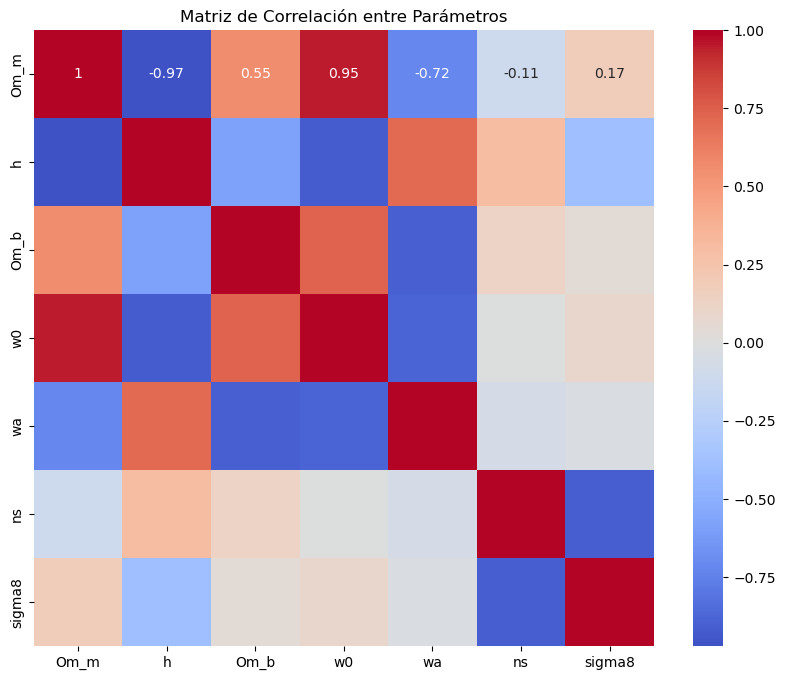

In [275]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import inv

# Invertir la matriz de Fisher para obtener la matriz de covarianza
cov_matrix = inv(Fis)

# Calcular la matriz de correlación
diag = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / np.outer(diag, diag)

# Etiquetas de los parámetros (puedes ajustarlas según tu modelo)
param_labels = ['Om_m', 'h', 'Om_b', 'w0', 'wa', 'ns', 'sigma8']

# Crear un gráfico de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=param_labels, yticklabels=param_labels, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación entre Parámetros')
plt.show()

_________________________
_________________________